In [153]:
# Scientific libraries
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, CartesianRepresentation, ICRS, GCRS,UnitSphericalRepresentation
# Graphic libraries

import matplotlib.pyplot as plt
%matplotlib notebook
from jupyterthemes import jtplot
plt.style.use('mike_dark') 
jtplot.style(context='notebook', fscale=1, grid=False)

from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')
from pyipn.io.plotting.projection import *
import stan_utility

green = "#1DEBA6"
red = "#FF0059"
yellow = "#F6EF5B"

from mpl_toolkits.mplot3d import Axes3D 


from pyipn import copy_template, Universe

[0.02079383 0.         0.88783046]


<IPython.core.display.Javascript object>


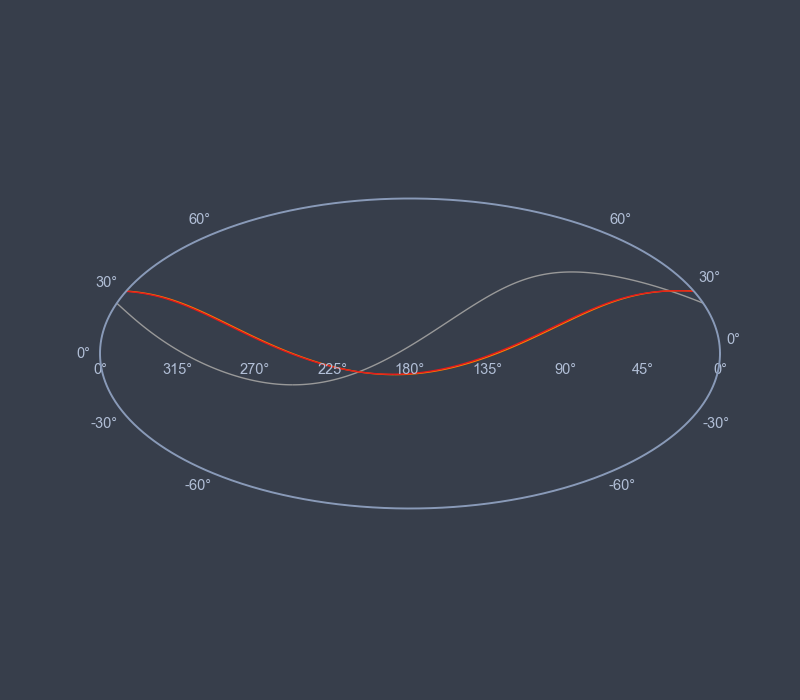

<IPython.core.display.Javascript object>


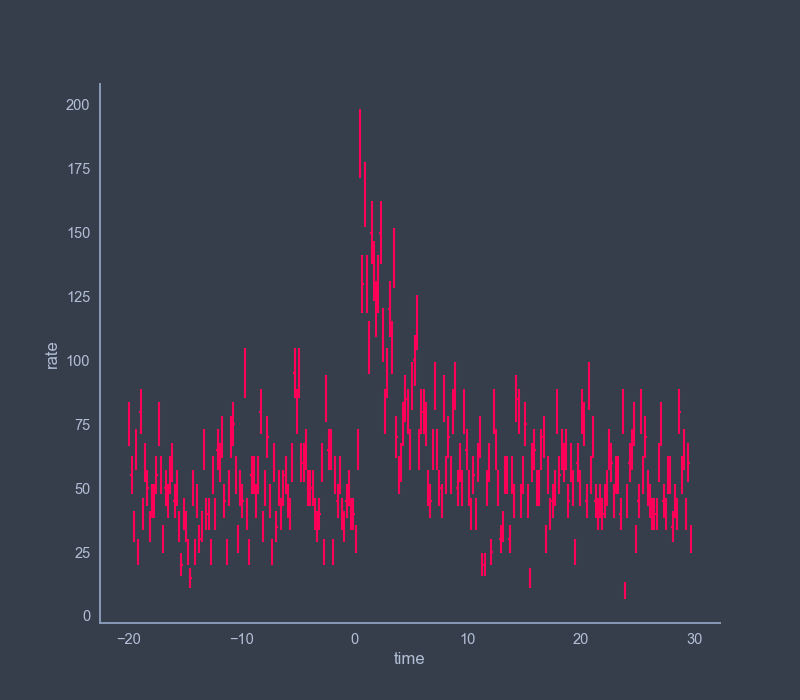

<IPython.core.display.Javascript object>


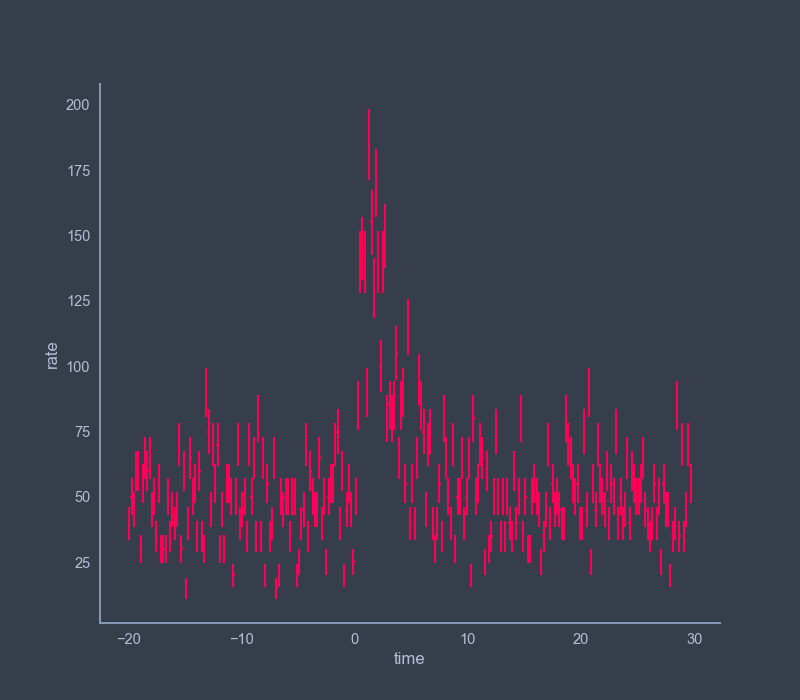

<IPython.core.display.Javascript object>


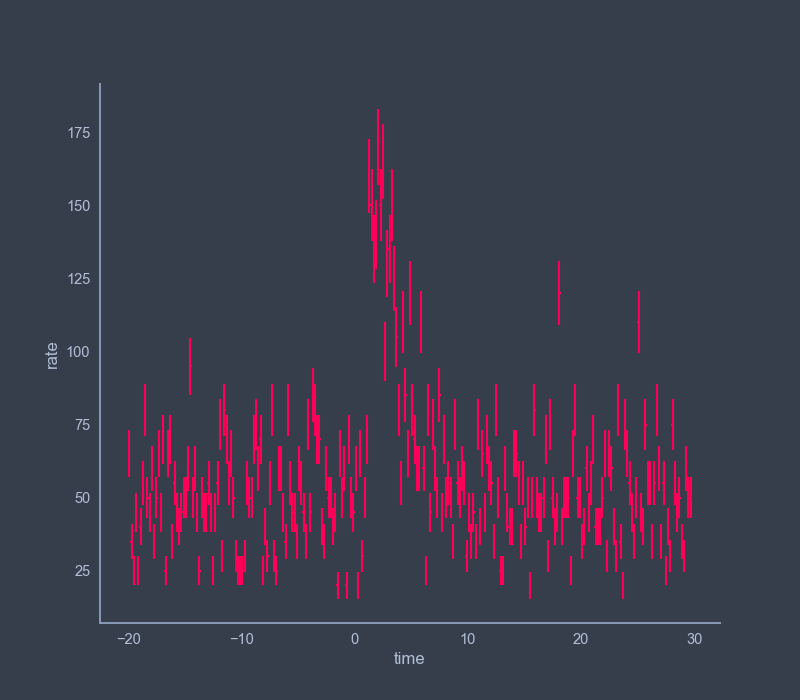

In [138]:

uni = Universe.from_yaml('template_3.yaml')
uni.explode_grb(tstart=-50,tstop=100)

print(uni._T0)

uni.plot_all_annuli(cmap='Set1_r',lw=1);
for det, lc in uni.light_curves.items():

    lc.display(-20,30,.2,color=red)



In [157]:
lc = uni.light_curves['det1']
counts, times = lc.get_binned_light_curve(-10.4,20.4,.2)
mid = np.mean([times[:-1],times[1:]], axis=0)
width = times[1:] - times[:-1]




lc2 = uni.light_curves['det2']

counts2, times2 = lc2.get_binned_light_curve(-10,20,.2)
mid2 = np.mean([times2[:-1],times2[1:]], axis=0)
width2 = times2[1:] - times2[:-1]


lc3 = uni.light_curves['det3']

counts3, times3 = lc3.get_binned_light_curve(-20,25,.5)
mid3 = np.mean([times3[:-1],times3[1:]], axis=0)
width3 = times3[1:] - times3[:-1]

d1 = uni.detectors['det1']
d2 = uni.detectors['det2']
d3 = uni.detectors['det3']

xyz1=d1.location.get_cartesian_coord().xyz.value
xyz2=d2.location.get_cartesian_coord().xyz.value
xyz3=d3.location.get_cartesian_coord().xyz.value


k=25

N_model = 100

predict_time = np.linspace(-20,40,N_model)
omega=np.random.randn(k)

data = dict(N1=len(counts),
            time1=mid,
            counts1=counts.astype(int),
            exposure1=width,
            exposure2=width2,
            N2=len(counts2),
            time2=mid2,
            counts2=counts2.astype(int),
            N3=len(counts3),
            time3=mid3,
            counts3=counts3.astype(int),
            exposure3=width3,
            
            
            k=k,
            bw=2.,
            bw2=1.,
            omega=omega,
            N_model=N_model,
            predict_time=predict_time,
            
            sc_pos1 = xyz1,
            sc_pos2 = xyz2,
             sc_pos3 = xyz3,
           
           
           
           )

In [158]:
model = stan_utility.compile_model('rff_loc3.stan', model_name='rff3')
#model = stan_utility.compile_model('gp_light_curve.stan', model_name='gplc')

Using cached StanModel


In [159]:
fit = model.sampling(warmup=500,iter=900,data=data, chains=8, seed=1234,
                     control = dict(max_treedepth=11, adapt_delta=.8)
                    

                    )

<IPython.core.display.Javascript object>


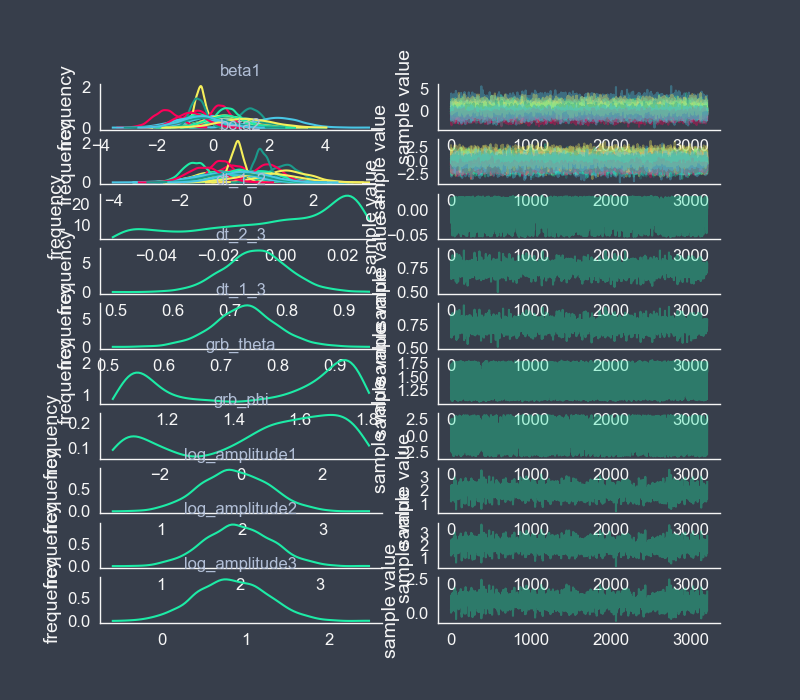

In [161]:
with plt.style.context('mike_dark'):
    fit.plot(['beta1','beta2',
              'dt_1_2',
                'dt_2_3',
                'dt_1_3',
              'grb_theta',
              'grb_phi',
              
              'log_amplitude1',
               'log_amplitude2',
              'log_amplitude3',
            #  'tstart',
         #     'tstop'
             
             ]);

<IPython.core.display.Javascript object>


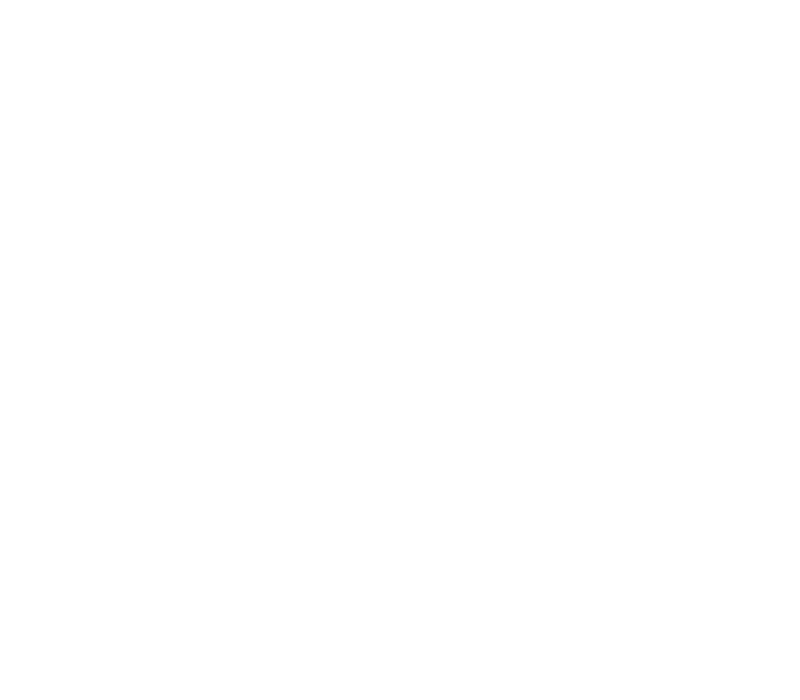

ValueError: No parameter predict

In [29]:
fig, ax = plt.subplots()

predict = fit.extract('predict')['predict']


for p in predict[::2]:

    ax.plot(predict_time,p, alpha=0.01, color=green )


<IPython.core.display.Javascript object>


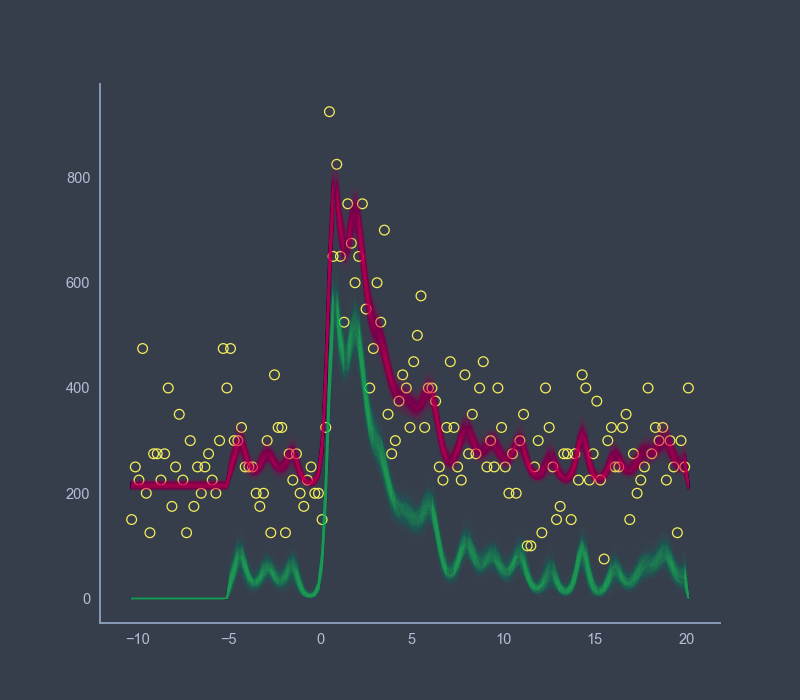

In [162]:
fig, ax = plt.subplots()

fhat = fit.extract("fhat1")["fhat1"]
bkg = fit.extract("bkg1")["bkg1"]

for y, b in zip(fhat[::10], bkg[::10]):

    ax.plot(mid, y, alpha=0.01, color=green)
    ax.plot(mid, (y + b), alpha=0.01, color=red)
#    ax.plot(mid,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts/width, edgecolor=yellow, facecolor="none", lw=0.9)

<IPython.core.display.Javascript object>


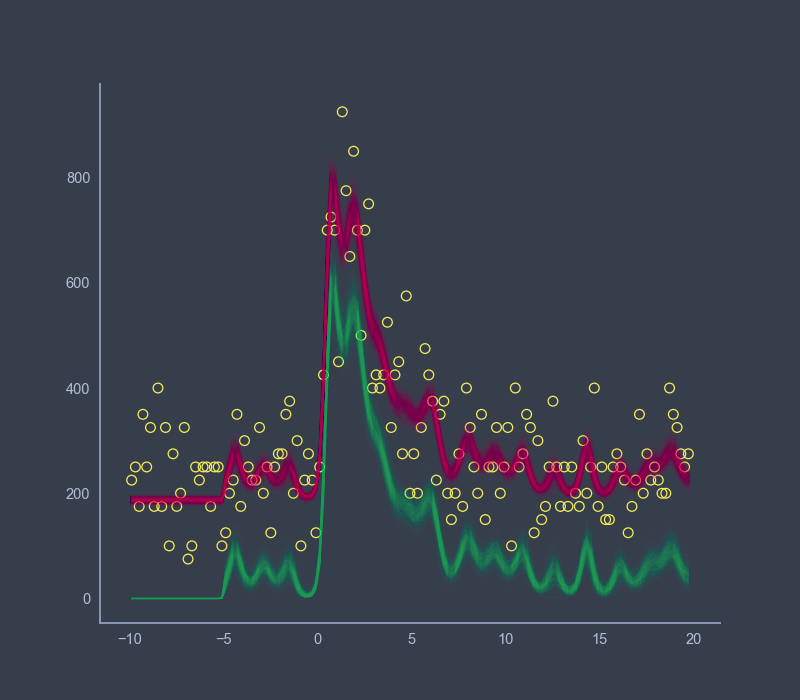

In [163]:
fig, ax = plt.subplots()

fhat = fit.extract('fhat2')['fhat2']
bkg = fit.extract('bkg2')['bkg2']

for y, b in zip(fhat[::10], bkg[::10]):

    ax.plot(mid2,y, alpha=0.01, color=green)
    ax.plot(mid2,y +b, alpha=0.01, color=red)
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid2, counts2/width2, edgecolor=yellow, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


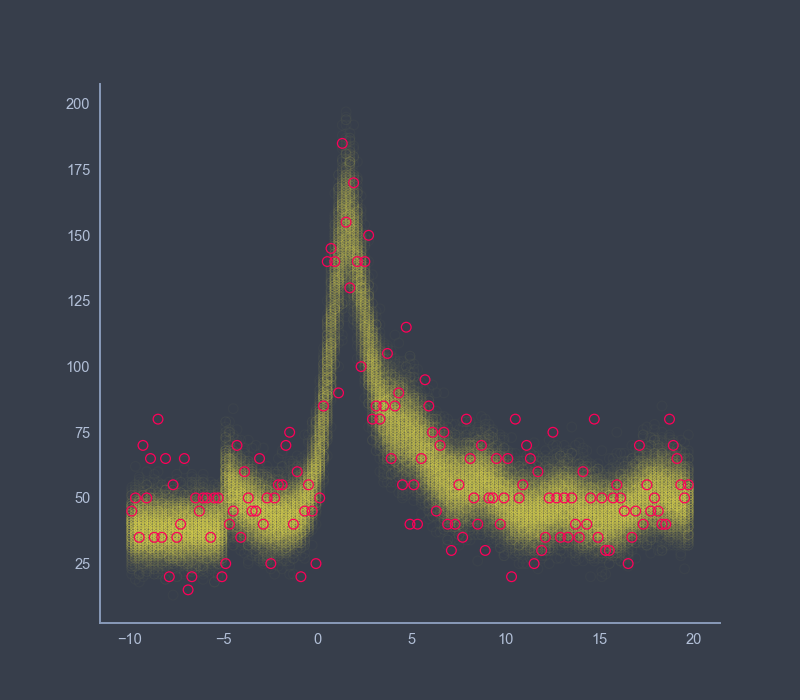

In [156]:
fig, ax = plt.subplots()

ppc2 = fit.extract('ppc2')['ppc2']


for p in ppc2[::10]:

    ax.scatter(mid2,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid2, counts2, edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


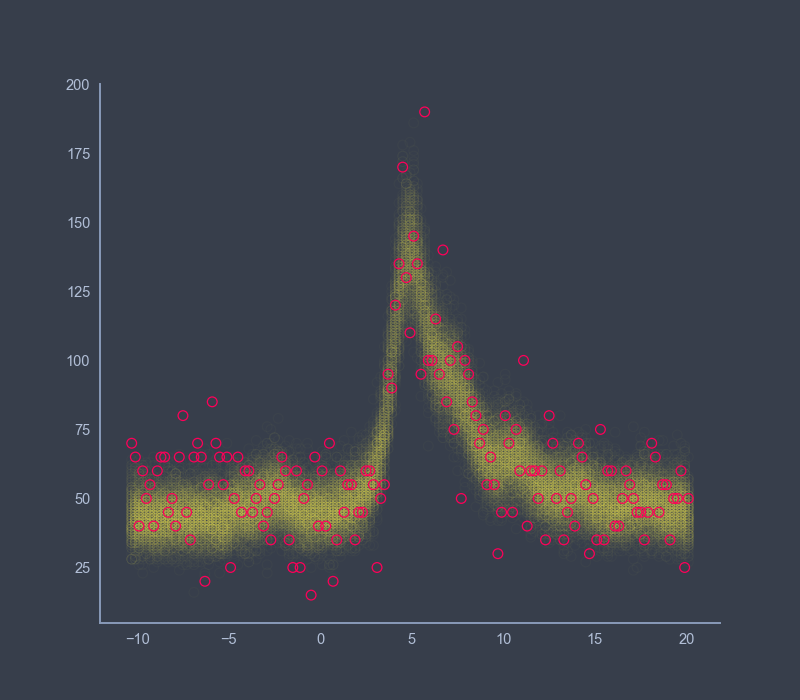

In [84]:
fig, ax = plt.subplots()

ppc1 = fit.extract('ppc1')['ppc1']


for p in ppc1[::10]:

    ax.scatter(mid,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts, edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


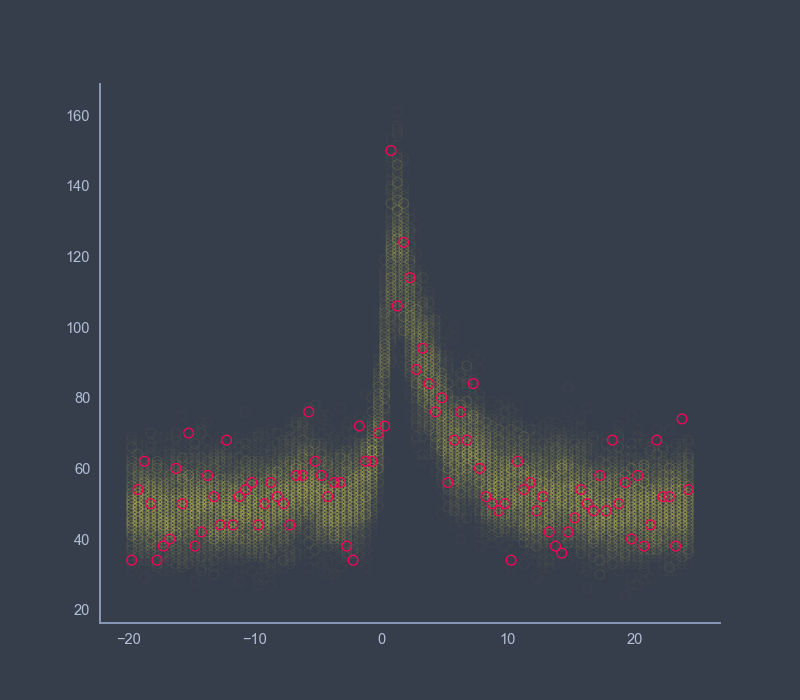

In [85]:
fig, ax = plt.subplots()

ppc3 = fit.extract('ppc3')['ppc3']


for p in ppc3[::10]:

    ax.scatter(mid3,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid3, counts3, edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


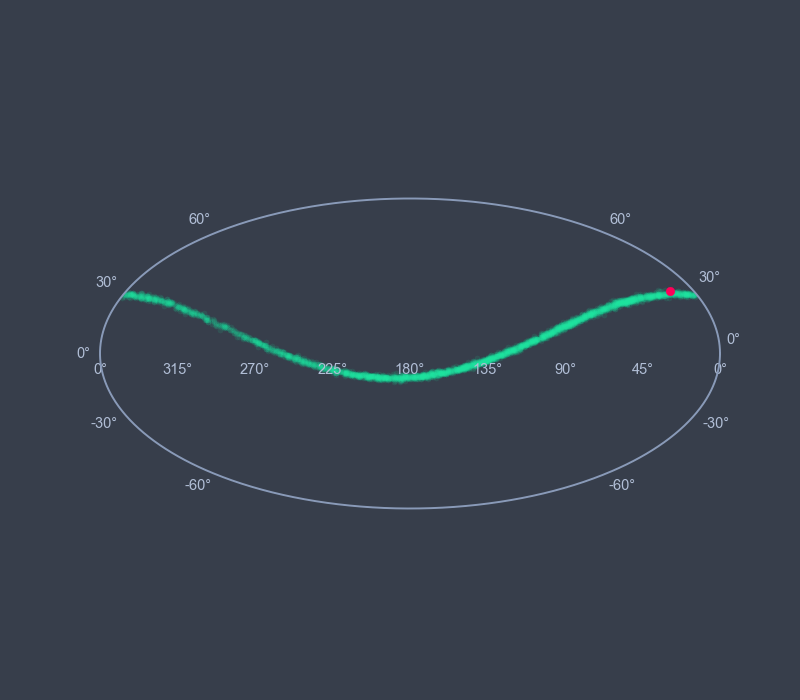

In [164]:
# fig = uni.plot_all_annuli(cmap='magma',lw=3);

# ax = fig.get_axes()[0]


fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide',
                                      # center=SkyCoord(135,-22,unit='deg')
                                      ))

theta = np.rad2deg(fit.extract('grb_theta')['grb_theta'])
phi = np.rad2deg(fit.extract('grb_phi')['grb_phi'])



idx = phi <= 0

phi[idx] +=360


ax.scatter(phi, -(theta-90), c=green, alpha=.1, transform=ax.get_transform("icrs"), s=15)
ax.scatter(np.array([15.]),np.array([30.]),c=red, s=40,transform=ax.get_transform("icrs"))

#uni.plot_all_annuli(cmap='magma',lw=3);

<IPython.core.display.Javascript object>


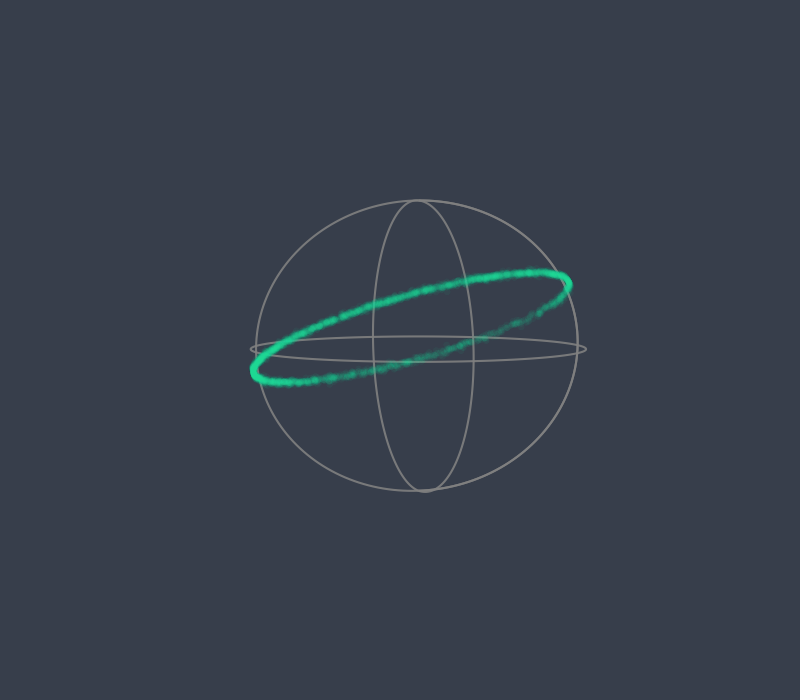

In [166]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
xyz = fit.extract('grb_xyz')['grb_xyz']


R=1

ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2],c=green,alpha=.05)
u1 = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x2 = R * np.outer(np.cos(u1), np.sin(v))
y2 = R * np.outer(np.sin(u1), np.sin(v))
z2 = R * np.outer(np.ones(np.size(u1)), np.cos(v))



ax.plot_wireframe(x2, y2, z2, color="grey", alpha=0.9, rcount=4, ccount=2)


ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
ax._axis3don = False


In [167]:

from pyipn.geometry import Location
from pyipn.io.plotting.spherical_circle import SphericalCircle
def compute_annulus_from_time_delay(time_delay, detector1, detector2, ax =None ,color=green,**kwargs):
    
    dxyz = (  detector2.location.get_cartesian_coord().xyz - detector1.location.get_cartesian_coord().xyz)
            
    dcart = Location(
    SkyCoord(
        x=dxyz[0],
        y=dxyz[1],
        z=dxyz[2],
        representation_type="cartesian",
        unit="km",
     #   frame='icrs'
    )
        )
    
    
    norm_d = dcart.get_norm_vec(u.km)
    
    distance = np.linalg.norm(dxyz) * u.km
    
    theta = np.arccos(
            np.around(((-const.c * time_delay*u.s ).to('km')/ distance).value, 15)
        )
    
    
    ra = dcart.coord.represent_as(UnitSphericalRepresentation).lon
    dec = dcart.coord.represent_as(UnitSphericalRepresentation).lat
    
    
    if ax is None:
        fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide'))
    
    circle = SphericalCircle(
            np.array([ra.value, dec.value]) * ra.unit,
            theta*u.rad,
            vertex_unit=u.deg,
            resolution=5000,
            edgecolor=color,
            facecolor="none",
            transform=ax.get_transform("icrs"),
        **kwargs
       
  
        )
    
    
   
    
    ax.add_patch(circle)
    
    
    
    
    
    
    
    
    
    
    
    
    
    

<IPython.core.display.Javascript object>


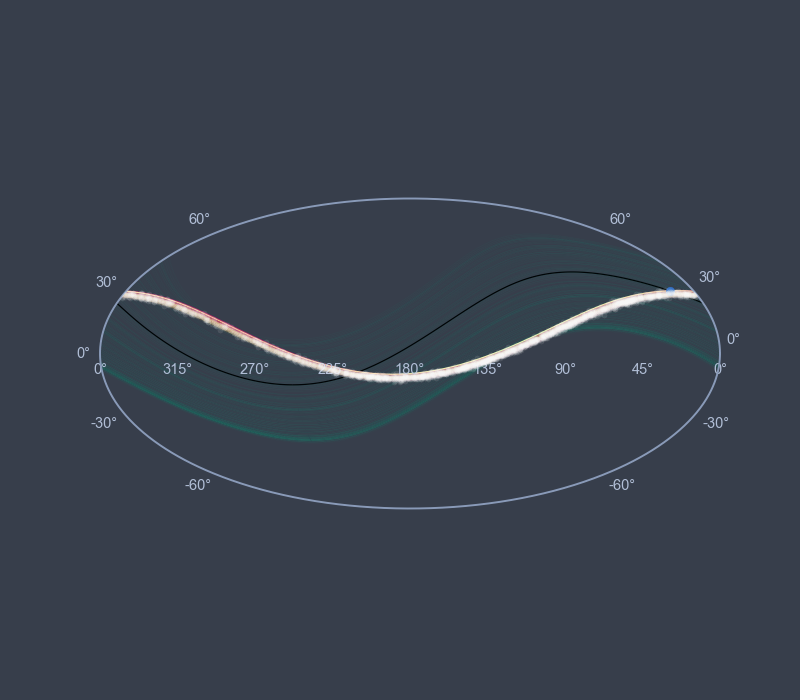

In [168]:
 dt = fit.extract('dt_1_2')['dt_1_2']
# fig, ax = plt.subplots(subplot_kw=dict(projection='astro globe',
#                                        center=SkyCoord(135,-22,unit='deg', frame='icrs') ))

fig = uni.plot_all_annuli(cmap='magma',lw=.9);

ax = fig.get_axes()[0]
for d in dt[::10]:

    compute_annulus_from_time_delay(d, detector1=uni.detectors['det1'],
                                    detector2=uni.detectors['det2'], ax = ax,alpha=.05 )
    

dt = fit.extract('dt_1_3')['dt_1_3']
#fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide'))
for d in dt[::10]:

    compute_annulus_from_time_delay(d, detector1=uni.detectors['det1'],
                                    detector2=uni.detectors['det3'], ax = ax,color=red,alpha=.05 )
    
    
    
    
dt = fit.extract('dt_2_3')['dt_2_3']
#fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide'))
for d in dt[::10]:

    compute_annulus_from_time_delay(d, detector1=uni.detectors['det2'],
                                    detector2=uni.detectors['det3'], ax = ax,color=yellow,alpha=.05 )
    
    
theta = np.rad2deg(fit.extract('grb_theta')['grb_theta'])
phi = np.rad2deg(fit.extract('grb_phi')['grb_phi'])



idx = phi <= 0

phi[idx] +=360


ax.scatter(phi, -(theta-90), c='w', alpha=.1, transform=ax.get_transform("icrs"), s=15,zorder=200)
    
ax.scatter(np.array([15.]),np.array([30.]),c='b', s=40,transform=ax.get_transform("icrs"), zorder=100)
    

<IPython.core.display.Javascript object>


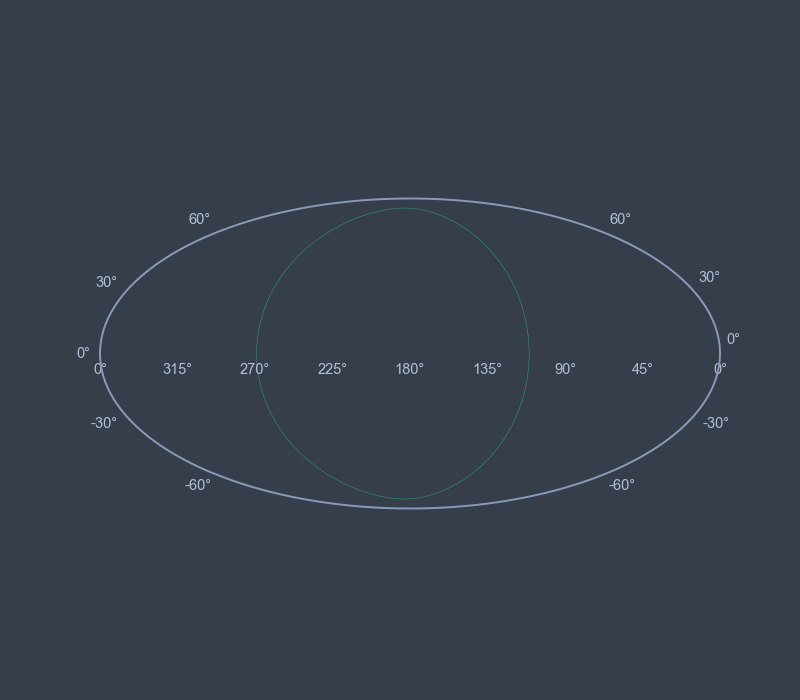

In [132]:
fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide'))


compute_annulus_from_time_delay(1.9, detector1=uni.detectors['det1'], detector2=uni.detectors['det2'], ax = ax )
    
   

In [55]:
n_verts = 3 * (3 - 1)/2
n_verts

3.0

<IPython.core.display.Javascript object>


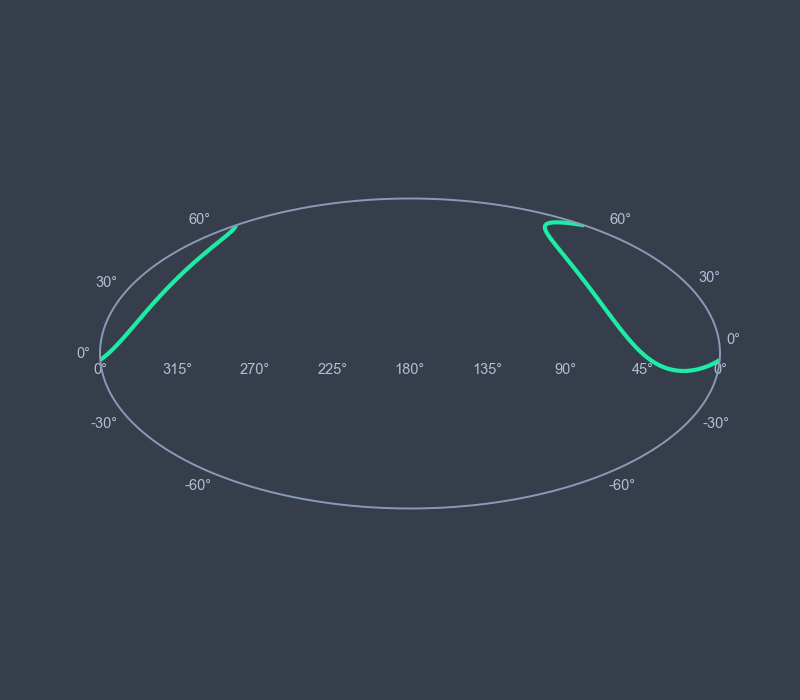

In [71]:
uni.plot_annulus('det1','det2',ec=green,fc='none',lw=3);

<IPython.core.display.Javascript object>


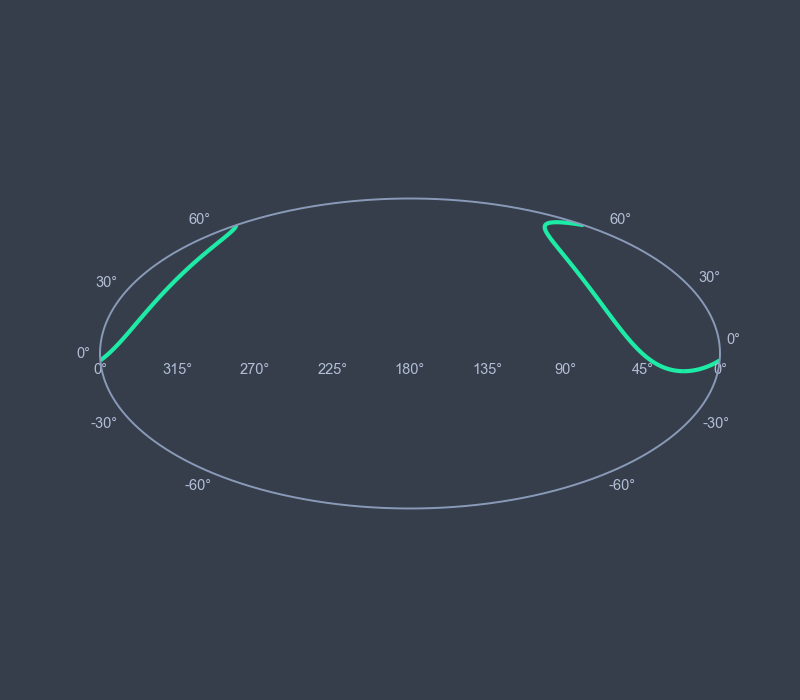

In [72]:
uni.plot_annulus('det1','det3',ec=green,fc='none',lw=3);

<IPython.core.display.Javascript object>


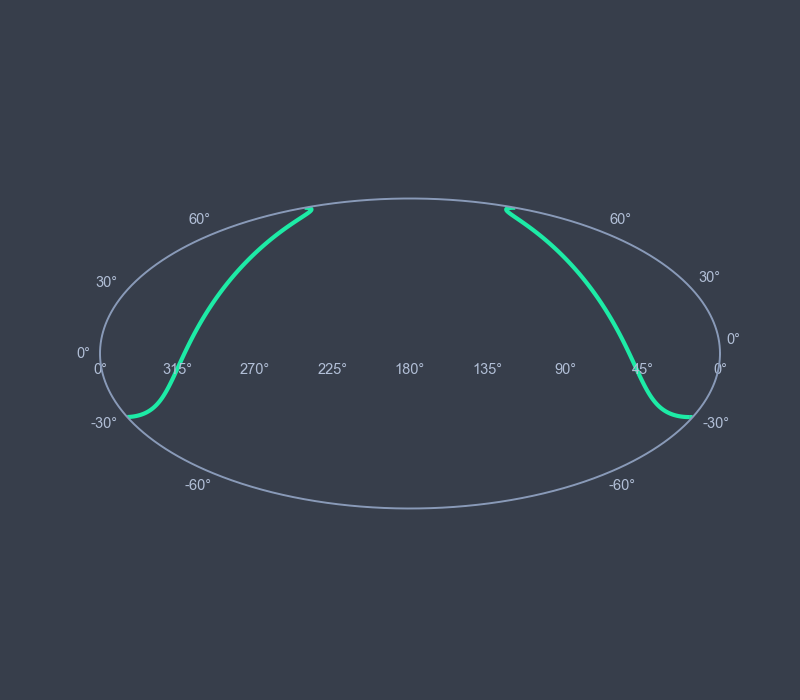

In [73]:
uni.plot_annulus('det2','det3',ec=green,fc='none',lw=3);

<IPython.core.display.Javascript object>


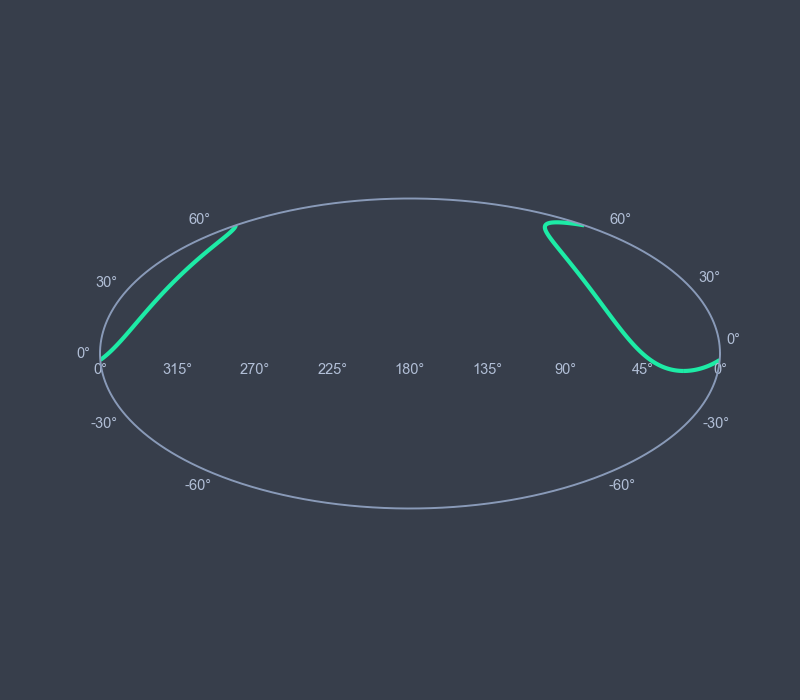

In [74]:
uni.plot_annulus('det2','det1',ec=green,fc='none',lw=3);

<IPython.core.display.Javascript object>


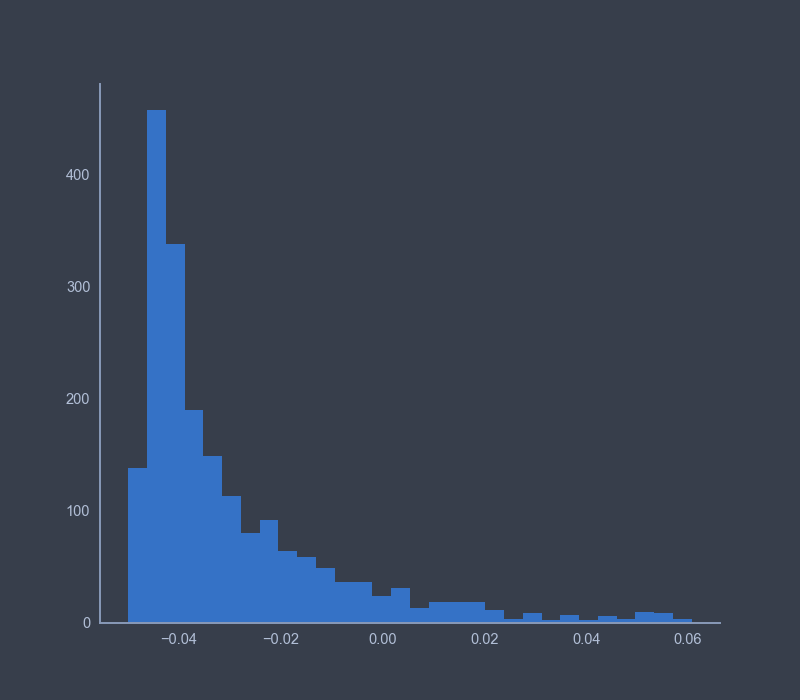

<IPython.core.display.Javascript object>


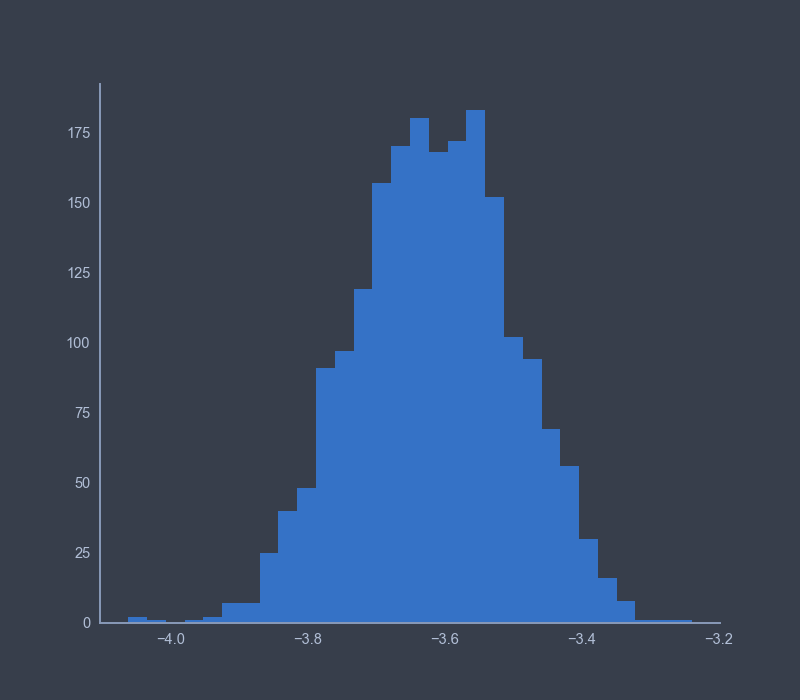

<IPython.core.display.Javascript object>


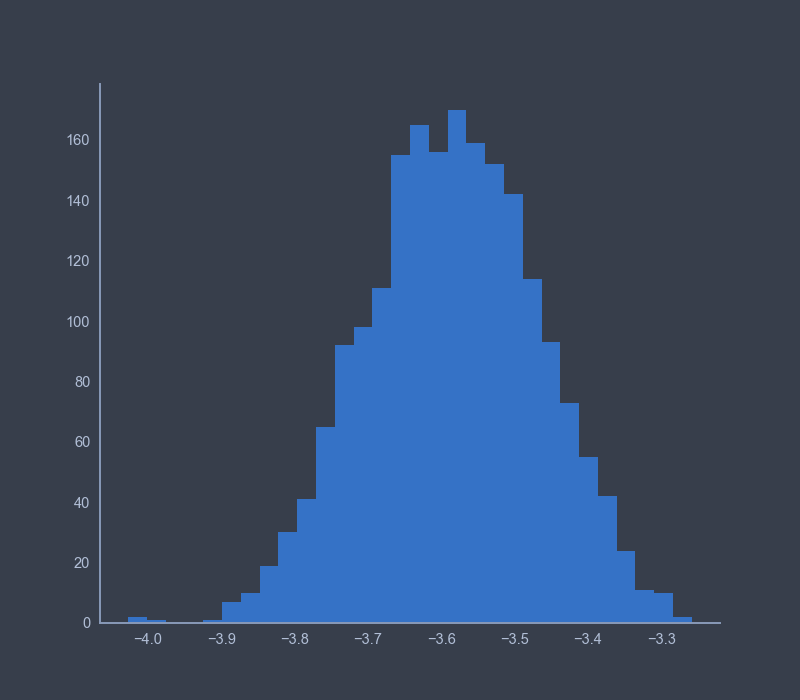

(array([  2.,   1.,   0.,   0.,   1.,   7.,  10.,  19.,  30.,  41.,  65.,
         92.,  98., 111., 155., 165., 156., 170., 159., 152., 142., 114.,
         93.,  73.,  55.,  42.,  24.,  11.,  10.,   2.]),
 array([-4.02702614, -4.00140956, -3.97579299, -3.95017641, -3.92455983,
        -3.89894326, -3.87332668, -3.8477101 , -3.82209353, -3.79647695,
        -3.77086037, -3.74524379, -3.71962722, -3.69401064, -3.66839406,
        -3.64277749, -3.61716091, -3.59154433, -3.56592776, -3.54031118,
        -3.5146946 , -3.48907803, -3.46346145, -3.43784487, -3.4122283 ,
        -3.38661172, -3.36099514, -3.33537857, -3.30976199, -3.28414541,
        -3.25852884]),
 <a list of 30 Patch objects>)

In [92]:
fig, ax = plt.subplots()


dt = fit.extract('dt_1_2')['dt_1_2']


ax.hist(dt,bins=30)

fig, ax = plt.subplots()
dt = fit.extract('dt_1_3')['dt_1_3']


ax.hist(dt,bins=30)

fig, ax = plt.subplots()
dt = fit.extract('dt_2_3')['dt_2_3']


ax.hist(dt,bins=30)

In [93]:
uni._T0

array([3.43026793, 3.44615154, 0.        ])

In [94]:
uni._time_differences

array([0.        , 3.43026793, 0.01588361])

In [112]:
def time_delay(phi, theta,d1,d2):
    
    xyz = SkyCoord(phi, theta, unit='deg',frame='icrs').represent_as(CartesianRepresentation).xyz.value
    
    c = 299792.46
    t1 = xyz.dot(d1.location.get_cartesian_coord().xyz.value)
    t2 = xyz.dot(d2.location.get_cartesian_coord().xyz.value)
    return (t1-t2)/c
    
    
    
    
    



In [123]:
dt = fit.extract('dt_1_3')['dt_1_3']

theta = fit.extract('grb_theta')['grb_theta']
phi = fit.extract('grb_phi')['grb_phi']


idx = phi <= 0

# phi[idx] +=360


theta -=90










In [119]:
xyz = SkyCoord(300, 0, unit='deg',frame='icrs').represent_as(CartesianRepresentation)
               
xyz.xyz

<Quantity [ 0.5      , -0.8660254,  0.       ]>

In [122]:
xyz = SkyCoord(300-360, 0, unit='deg',frame='icrs').represent_as(CartesianRepresentation)
               
xyz.xyz

<Quantity [ 0.5      , -0.8660254,  0.       ]>

In [116]:
thin = 100

for p,t,d in zip(phi[::thin], theta[::thin], dt[::thin]):


    print (d, time_delay(p, t, uni.detectors['det1'],uni.detectors['det3']))

-3.7180699698438384 0.9509267223635957
-3.9538965752446145 0.9472392049757149
-3.4197286574588754 0.9484475660792745
-3.7349249669183386 0.9491419600354101
-3.745795070603994 0.9530261426394789
-3.5172700772200947 0.9469782810080508
-3.5698322971722303 0.950170710737349
-3.6492984225736262 0.9503916663802416
-3.6480069222786544 0.9443671837241518
-3.7720380407287877 0.9466133915267886
-3.534668855977064 0.951264067020147
-3.6352998235957292 0.9463810747354041
-3.8178282104187993 0.9453309082047268
-3.8110147510031926 0.9450445488923463
-3.6025119007504234 0.9448347645022154
-3.693544851636065 0.9636581126123172
-3.5419244907179674 0.9559074287413271
-3.49343977250928 0.9461637813736093
-3.623861355588605 0.9451718675066165
-3.605937515932282 0.9441374363282355
